In [1]:
import cmath 
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from tqdm import tqdm

class Runge_Kutta_4(ABC):
    def __init__(self, function=None, initial_y=None, discretization=0.01, interval=1., is_function_depends_on_x=False, num_objects=1):
        """
        :param function: np.array, матрица ДУ
        :param discretization: float, шаг интегрирования
        :param interval: float, интервал интегрирования
        :param initial_y: np.array, начальные условия
        """
        self.function = function if function is not None else []
        self.discretization = discretization
        self.interval = interval
        self.initial_y = initial_y if initial_y is not None else []
        self.is_function_depends_on_x = is_function_depends_on_x
        self.computations_complited = False
        self.num_objects = num_objects
        
    @abstractmethod
    def get_function(self, x, num, y):
        """
        :param x: float, координата x
        """
        pass
    
    
    def get_derivative(self, function, y):
        """
        :param function: np.array, функция ДУ
        :param psi: np.array, значение вектора y
        """
        return function @ y
    
    def run(self):
        
        N = int(self.interval / self.discretization) + 1
        y = [self.initial_y for _ in range(N)]
        y[0] = self.initial_y
        x_range = [i * self.discretization for i in range(N)]
        h = self.discretization
        y_new = [[] for _ in range(self.num_objects)]

        for n in range(N - 1):
            x_n = x_range[n]
            for obj in range(self.num_objects):
                if self.is_function_depends_on_x:
                    function_n = self.get_function(x_n, obj, y[n])
                    function_n_half_h = self.get_function(x_n + h / 2, obj, y[n])
                    function_n_h = self.get_function(x_n + h, obj, y[n])
                else:
                    function_n = self.function
                    function_n_half_h = self.function
                    function_n_h = self.function
                k_1 = self.get_derivative(function_n, y[n][:][obj]) 
                k_2 = self.get_derivative(function_n_half_h, y[n][:][obj] + k_1 * h / 2)
                k_3 = self.get_derivative(function_n_half_h, y[n][:][obj] + k_2 * h / 2)
                k_4 = self.get_derivative(function_n_h, y[n][:][obj] + k_3 * h)
                new = y[n][obj] + h / 6 * (k_1 + 2 * k_2 + 2 * k_3 + k_4)
                y[n][obj] = new
                y_new[obj].append(new)

                
        self.computations_complited = True
        y = np.array(y_new)

    
        return y
    

   
class Shredinger_chain_spins(Runge_Kutta_4):
    def __init__(self, J_ort=1, J_z=1):
        super().__init__()
        self.J_ort = J_ort
        self.J_z = J_z
        
    def get_function(self, x, num, y):
        """
        :param x: float, координата x
        """
        neigh = (num - 1) % self.num_objects
        S_neigh_x, S_neigh_y, S_neigh_z = y[neigh][0], y[neigh][1], y[neigh][2]
        function = np.array([[0, - self.J_z * S_neigh_z, self.J_ort * S_neigh_y],
                        [self.J_z * S_neigh_z, 0, -self.J_ort * S_neigh_x],
                        [-self.J_ort * S_neigh_y, self.J_ort * S_neigh_x, 0]])
        
        neigh = (num + 1) % self.num_objects
        S_neigh_x, S_neigh_y, S_neigh_z = y[neigh][0], y[neigh][1], y[neigh][2]
        function += np.array([[0, - self.J_z * S_neigh_z, self.J_ort * S_neigh_y],
                        [self.J_z * S_neigh_z, 0, -self.J_ort * S_neigh_x],
                        [-self.J_ort * S_neigh_y, self.J_ort * S_neigh_x, 0]])
        
        return function
    

In [2]:
def inversal_method(border, slope, z):
    return (-1 + np.sqrt(1 + 4 * z * slope * border)) / (2 * slope)

def generate_linear_distr(border, slope, num_conditions):
    left = ((1 - 2 * slope * border)**2 - 1) / (4 * border * slope)
    right = ((1 + 2 * slope * border)**2 - 1) / (4 * border * slope)
    uni = np.random.uniform(left, right, num_conditions)
    linear = []
    for z_uni in uni:
        linear.append(inversal_method(border, slope, z_uni))
    return linear

def generate_initial_conditions(s_0, slope_s_0, num_conditions):
    s_0_x = np.array(generate_linear_distr(s_0, slope_s_0, num_conditions))
    phi = np.random.uniform(0, 2 * np.pi, num_conditions)
    s_0_y = np.sqrt(s_0**2 - s_0_x**2) * np.cos(phi)
    s_0_z = np.sqrt(s_0**2 - s_0_x**2) * np.sin(phi)
    return s_0_x, s_0_y, s_0_z

def generate_initial_conditions_random(s_0, num_conditions):
    phi = np.random.uniform(0, 2 * np.pi, num_conditions)
    cos_theta = np.random.uniform(-1, 1, num_conditions)
    sin_theta = np.sqrt(1 - cos_theta ** 2)
    s_0_x = s_0 * np.cos(phi) * sin_theta
    s_0_y = s_0 * np.sin(phi) * sin_theta
    s_0_z = s_0 * cos_theta
    return s_0_x, s_0_y, s_0_z

def generate_initial_conditions_random_with_perturbation(s_0, num_conditions):
    delta_phi = np.random.uniform(-1e-5, 1e-5)
    phi = np.random.uniform(0, 2 * np.pi, num_conditions)
    cos_theta = np.random.uniform(-1, 1, num_conditions)
    sin_theta = np.sqrt(1 - cos_theta ** 2)
    s_0_x = s_0 * np.cos(phi) * sin_theta
    s_0_y = s_0 * np.sin(phi) * sin_theta
    s_0_z = s_0 * cos_theta
    s_0_x_p = s_0 * np.cos(phi + delta_phi) * sin_theta
    s_0_y_p = s_0 * np.sin(phi + delta_phi) * sin_theta
    s_0_z_p = s_0 * cos_theta
    return s_0_x, s_0_y, s_0_z, s_0_x_p, s_0_y_p, s_0_z_p

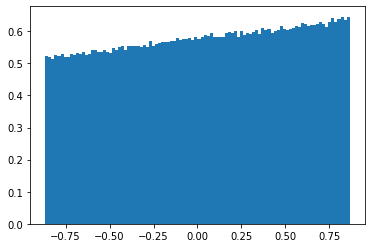

In [3]:
s = np.sqrt(3) / 2
slope = 1 / s / 20
st = generate_linear_distr(s, slope, 1000000)
count, bins, ignored = plt.hist(st, 100, density=True)
plt.show()

Ошибочка вышла

In [3]:
s = np.sqrt(3) / 2
slope = 1 / s / 20
num_conditions = 1

problem = Shredinger_chain_spins()
problem.num_objects = 11
problem.J_z = 0.82
problem.J_ort = -0.41
problem.discretization = 0.01
problem.interval = 150
problem.is_function_depends_on_x = True
s_0_x, s_0_y, s_0_z = generate_initial_conditions(s, slope, num_conditions * problem.num_objects)
ans = []
for state in tqdm(range(num_conditions)):
    problem.initial_y = np.array([[s_0_x[state * problem.num_objects + n], 
                                   s_0_y[state * problem.num_objects + n],
                                   s_0_z[state * problem.num_objects + n]]
                                  for n in range(problem.num_objects)])
    ans.append(problem.run())

100%|██████████| 1/1 [00:09<00:00,  9.69s/it]


In [41]:
time_interval = 15
f_array = []
for i in range(num_conditions):
    M_x = ans[i].sum(axis=0)[:, 0]
    f = np.array([0 for _ in range(int(time_interval / problem.discretization))])
    sum_border = int((problem.interval - time_interval) / problem.discretization)
    for n in range(int(time_interval / problem.discretization)):
        f[n] = M_x[:sum_border] @ M_x[n:sum_border + n] / problem.discretization
    f_array.append(f) 

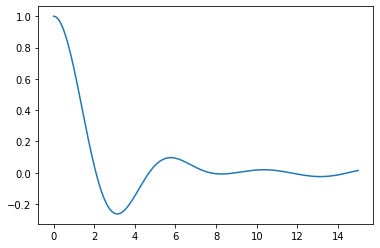

In [43]:
aver_f = np.array(f_array).sum(axis=0) / num_conditions
F = aver_f / aver_f[0]
t = [i * problem.discretization for i in range(len(F))]
plt.plot(t, F)

In [4]:
s = np.sqrt(3) / 2
# slope = 1 / s / 20
num_conditions = 100

problem = Shredinger_chain_spins()
problem.num_objects = 11
problem.J_z = 0.82
problem.J_ort = -0.41
problem.discretization = 0.01
problem.interval = 150
problem.is_function_depends_on_x = True
s_0_x, s_0_y, s_0_z = generate_initial_conditions_random(s, num_conditions * problem.num_objects)
ans_pr_1 = []
for state in tqdm(range(num_conditions)):
    problem.initial_y = np.array([[s_0_x[state * problem.num_objects + n], 
                                   s_0_y[state * problem.num_objects + n],
                                   s_0_z[state * problem.num_objects + n]]
                                  for n in range(problem.num_objects)])
    ans_pr_1.append(problem.run())

100%|██████████| 100/100 [16:30<00:00,  9.90s/it]


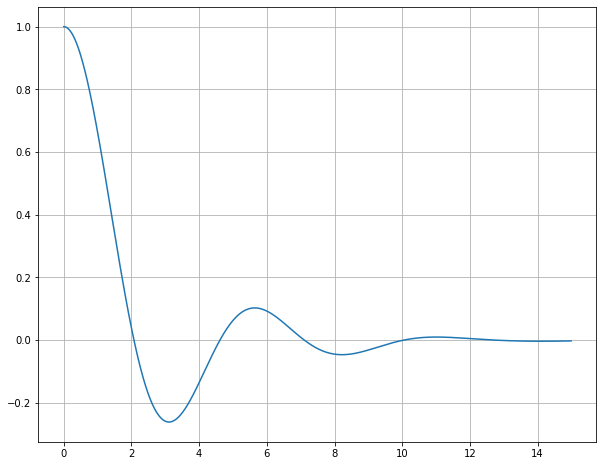

In [5]:
time_interval = 15
problem_interval = 150
f_array = []
num_conditions = 100
problem.discretization = 0.01
for i in range(num_conditions):
    M_x = ans_pr_1[i].sum(axis=0)[:, 0]
    f = np.array([0 for _ in range(int(time_interval / problem.discretization))])
    sum_border = int((problem_interval - time_interval) / problem.discretization)
    for n in range(int(time_interval / problem.discretization)):
        f[n] = M_x[:sum_border] @ M_x[n:sum_border + n] / problem.discretization
    f_array.append(f) 
aver_f = np.array(f_array).sum(axis=0) / num_conditions
F = aver_f / aver_f[0]
t = [i * problem.discretization for i in range(len(F))]
fig = plt.figure(figsize=(10,8))
plt.plot(t, F)

# half_conditions = int(num_conditions / 2)
# half_aver_f = np.array(f_array[:half_conditions]).sum(axis=0) / half_conditions
# half_F = half_aver_f / half_aver_f[0]
# plt.plot(t, half_F)
plt.grid()

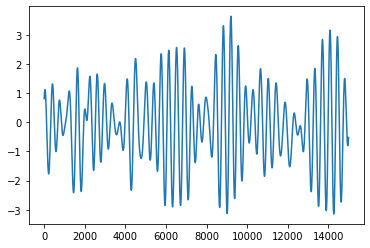

In [123]:
plt.plot(M_x)

In [33]:
sum(s_0_x)

0.7983786099999999

In [118]:
M=[np.array([0.02664294, 0.141231  , 0.85401637]),
          np.array([ 0.27959467, -0.81944111,  0.01852256]),
          np.array([-0.51171805, -0.33539355,  0.61290766]),
          np.array([ 0.30702513, -0.44836764,  0.67431598]),
          np.array([0.17351233, 0.04317794, 0.847366  ]),
          np.array([0.0554073 , 0.12852475, 0.85464111]),
          np.array([-0.36899078,  0.35481153,  0.69853746]),
          np.array([0.39224928, 0.71849006, 0.28268806]),
          np.array([0.13360355, 0.05162925, 0.85409866]),
          np.array([-0.19952932, -0.59004467,  0.60169372]),
          np.array([ 0.51058156, -0.10319089,  0.69185122])]
s_0_x = [i[0] for i in M]
s_0_y = [i[1] for i in M]
s_0_z = [i[2] for i in M]


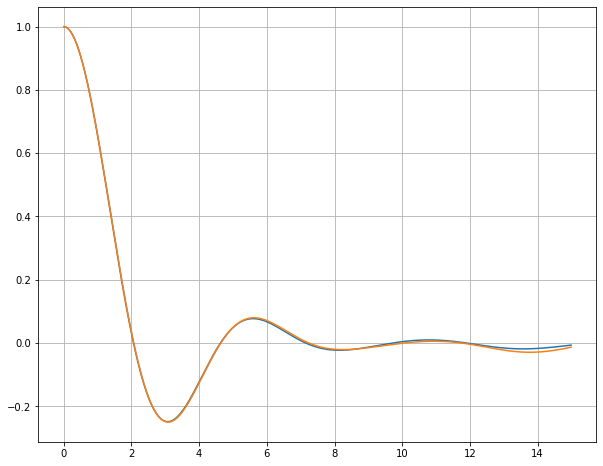

In [177]:
time_interval = 15
problem_interval = 150
f_array = []
num_conditions = 100
problem.discretization = 0.01
for i in range(num_conditions):
    M_x = ans_pr_1[i].sum(axis=0)[:, 0]
    f = np.array([0 for _ in range(int(time_interval / problem.discretization))])
    sum_border = int((problem_interval - time_interval) / problem.discretization)
    for n in range(int(time_interval / problem.discretization)):
        f[n] = M_x[:sum_border] @ M_x[n:sum_border + n] / problem.discretization
    f_array.append(f) 
aver_f = np.array(f_array).sum(axis=0) / num_conditions
F = aver_f / aver_f[0]
t = [i * problem.discretization for i in range(len(F))]
fig = plt.figure(figsize=(10,8))
plt.plot(t, F)

half_conditions = int(num_conditions / 2)
half_aver_f = np.array(f_array[:half_conditions]).sum(axis=0) / half_conditions
half_F = half_aver_f / half_aver_f[0]
plt.plot(t, half_F)
plt.grid()

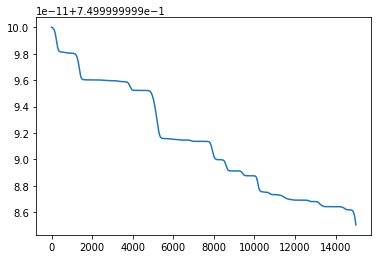

In [166]:
plt.plot(ans[0][0][:, 0] ** 2 + ans[0][0][:, 1] ** 2 + ans[0][0][:, 2] ** 2 )

In [167]:
s = np.sqrt(3) / 2
# slope = 1 / s / 20
num_conditions = 100

problem = Shredinger_chain_spins()
problem.num_objects = 11
problem.J_z = 1.
problem.J_ort = 0.
problem.discretization = 0.01
problem.interval = 150
problem.is_function_depends_on_x = True
s_0_x, s_0_y, s_0_z = generate_initial_conditions_random(s, num_conditions * problem.num_objects)
ans_pr_1_add = []
for state in tqdm(range(num_conditions)):
    problem.initial_y = np.array([[s_0_x[state * problem.num_objects + n], 
                                   s_0_y[state * problem.num_objects + n],
                                   s_0_z[state * problem.num_objects + n]]
                                  for n in range(problem.num_objects)])
    ans_pr_1_add.append(problem.run())

100%|██████████| 100/100 [21:40<00:00, 13.00s/it]


# Ising + analytical

<ipython-input-172-461d6289d45f>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(t,(np.sin(t) / t) ** 2, color='purple')


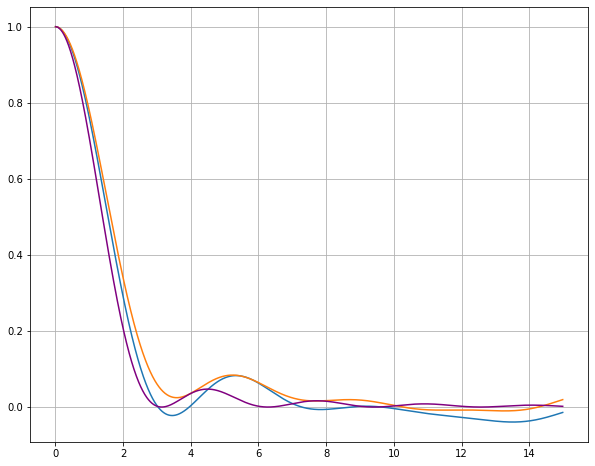

In [172]:
time_interval = 15
problem_interval = 150
f_array = []
num_conditions = 100
problem.discretization = 0.01
for i in range(num_conditions):
    M_x = ans_pr_1_add[i].sum(axis=0)[:, 0]
    f = np.array([0 for _ in range(int(time_interval / problem.discretization))])
    sum_border = int((problem_interval - time_interval) / problem.discretization)
    for n in range(int(time_interval / problem.discretization)):
        f[n] = M_x[:sum_border] @ M_x[n:sum_border + n] / problem.discretization
    f_array.append(f) 
aver_f = np.array(f_array).sum(axis=0) / num_conditions
F = aver_f / aver_f[0]
t = [i * problem.discretization for i in range(len(F))]
fig = plt.figure(figsize=(10,8))
plt.plot(t, F)

half_conditions = int(num_conditions / 2)
half_aver_f = np.array(f_array[:half_conditions]).sum(axis=0) / half_conditions
half_F = half_aver_f / half_aver_f[0]
plt.plot(t, half_F)
plt.plot(t,(np.sin(t) / t) ** 2, color='purple')
plt.grid()

In [173]:
s = np.sqrt(3) / 2
slope = 1 / s / 20
num_conditions = 10000

problem = Shredinger_chain_spins()
problem.num_objects = 11
problem.J_z = 0.82
problem.J_ort = -0.41
problem.discretization = 0.01
problem.interval = 15
problem.is_function_depends_on_x = True
s_0_x, s_0_y, s_0_z = generate_initial_conditions(s, slope, num_conditions * problem.num_objects)
ans_pr_2_add = []
for state in tqdm(range(num_conditions)):
    problem.initial_y = np.array([[s_0_x[state * problem.num_objects + n], 
                                   s_0_y[state * problem.num_objects + n],
                                   s_0_z[state * problem.num_objects + n]]
                                  for n in range(problem.num_objects)])
    ans_pr_2_add.append(problem.run())

100%|██████████| 10000/10000 [2:57:27<00:00,  1.06s/it] 


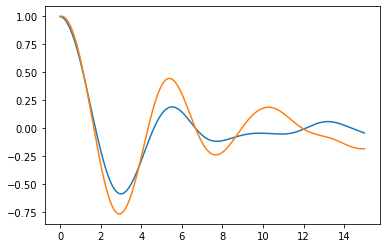

In [97]:
aver_M = 0
for i in range(num_conditions):
    M_x = ans_pr_2[i].sum(axis=0)[:, 0]
    aver_M += M_x / num_conditions
    
F_2 = aver_M / aver_M[0]
t = [i * problem.discretization for i in range(len(F_2))]
plt.plot(t, F_2)

aver_M = 0
half_conditions = int(num_conditions / 2)
for i in range(half_conditions):
    M_x = ans_pr_2[i].sum(axis=0)[:, 0]
    aver_M += M_x / half_conditions
    
half_F_2 = aver_M / aver_M[0]
t = [i * problem.discretization for i in range(len(half_F_2))]
plt.plot(t, half_F_2)


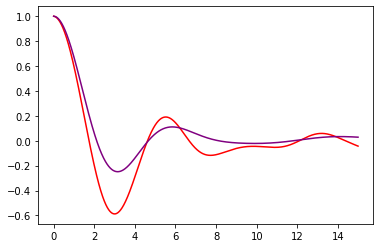

In [104]:
plt.plot(t, F_2, color='r')
plt.plot(t, F, color='purple')

# 10000 samples + comparison

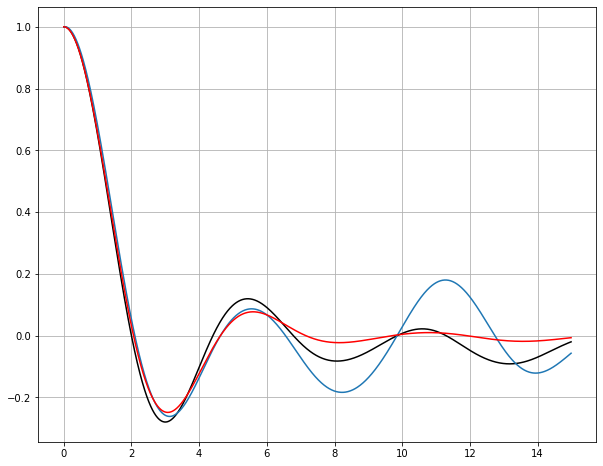

In [184]:
aver_M_add = 0
num_conditions = 10000
for i in range(num_conditions):
    M_x_add = ans_pr_2_add[i].sum(axis=0)[:, 0]
    aver_M_add += M_x_add / num_conditions

    
F_2 = aver_M_add / aver_M_add[0]
t = [i * problem.discretization for i in range(len(F_2))]
fig = plt.figure(figsize=(10,8))
plt.grid()
plt.plot(t, F_2, color='k')

aver_M_add = 0
half_conditions = int(num_conditions / 2)
for i in range(half_conditions):
    M_x = ans_pr_2_add[i].sum(axis=0)[:, 0]
    aver_M_add += M_x / half_conditions
    
half_F_2 = aver_M_add / aver_M_add[0]
t = [i * problem.discretization for i in range(len(half_F_2))]
plt.plot(t, half_F_2)
plt.plot(t, F, color='r')


# HW 9 Pr 1

In [6]:
from scipy.sparse.linalg import eigsh
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
def sigma_x():
    return np.array([[0, 1], [1, 0]])

def sigma_y():
    i = complex(0, 1)
    return np.array([[0, i], [-i, 0]])

def sigma_z():
    return np.array([[1, 0], [0, -1]])

def sigma_plus():
    return np.array([[0, 1], [0, 0]])

def sigma_minus():
    return np.array([[0, 0], [1, 0]])

def ising_chain(num_spins):
    qouplings = [(i, (i + 1) % num_spins) for i in range(num_spins)]
    chain = 0
    for qoupling in qouplings:
        k, l = qoupling[0], qoupling[1]  
        if k > l:
            k, l = l, k
        right_tensor_product = np.eye(2 ** (num_spins - l - 1))
        middle_tensor_product = np.eye(2 ** (l - k - 1))
        left_tensor_product = np.eye(2 ** (k))
        
        construct = np.kron(sigma_z(), right_tensor_product)
        construct = np.kron(middle_tensor_product, construct)
        construct = np.kron(sigma_z(), construct)
        construct = np.kron(left_tensor_product, construct)
        chain += construct
        
    return chain

def flip_flop_chain(num_spins):
    qouplings = [(i, (i + 1) % num_spins) for i in range(num_spins)]
    chain = 0
    for qoupling in qouplings:
        k, l = qoupling[0], qoupling[1]  
        if k > l:
            k, l = l, k
        right_tensor_product = np.eye(2 ** (num_spins - l - 1))
        middle_tensor_product = np.eye(2 ** (l - k - 1))
        left_tensor_product = np.eye(2 ** (k))
        
        construct = np.kron(sigma_plus(), right_tensor_product)
        construct = np.kron(middle_tensor_product, construct)
        construct = np.kron(sigma_minus(), construct)
        construct = np.kron(left_tensor_product, construct)
        chain += construct
        
        construct = np.kron(sigma_minus(), right_tensor_product)
        construct = np.kron(middle_tensor_product, construct)
        construct = np.kron(sigma_plus(), construct)
        construct = np.kron(left_tensor_product, construct)
        chain += construct
        
    return chain



In [8]:
J_z = 0.82
J_ort = -0.41
spins = 9
Hamiltonian = 0.25 * J_z * ising_chain(spins) + 0.5 * J_ort * flip_flop_chain(spins)

In [13]:
eigenvalues, eigenvectors = np.linalg.eig(Hamiltonian)
eigenvalues = eigenvalues.real

In [53]:
(Hamiltonian @ eigenvectors[:, 0] - eigenvectors[:, 0] * eigenvalues[0]).sum()

(5.9679813954518644e-15+0j)

In [19]:
dif_matrix = []
for i in range(len(eigenvalues)):
    dif_matrix.append(eigenvalues[i] - eigenvalues)

In [29]:
M_x = np.array([np.kron(np.eye(2 ** (spins - i - 1)), np.kron(sigma_x(), np.eye(2 ** i))) for i in range(spins)]).sum(axis=0)

In [30]:
M_m_j = np.transpose(eigenvectors) @ M_x @ eigenvectors

In [67]:
fid = []
discr = 0.1
time_len = 15
time = [discr * i for i in range(int(time_len / discr))]

for t in time:
    fid.append((M_m_j * np.transpose(M_m_j) * np.cos(np.array(dif_matrix) * t)).sum())

fid = np.array(fid) / fid[0]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


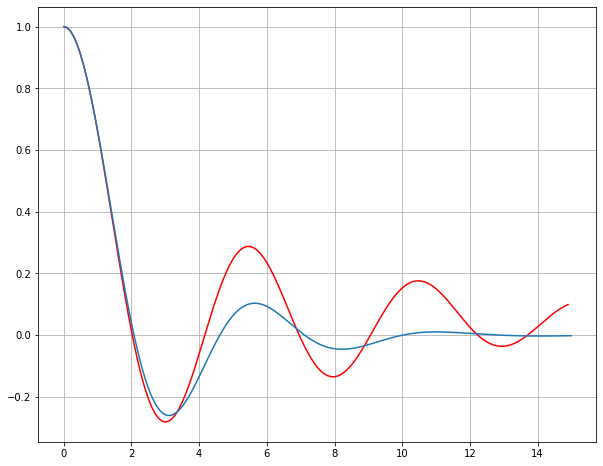

In [68]:
fig = plt.figure(figsize=(10,8))
plt.grid()
plt.plot(time, fid, color='r')

t = [i * problem.discretization for i in range(len(F))]
plt.plot(t, F)